# Meta
https://www.python-graph-gallery.com/324-map-a-color-to-network-nodes \

https://networkx.org/documentation/stable/index.html


# Audible Data Analysis

#### Data Scraped on 5/10/21

### Introduction
This notebook documents the data analysis of the title and category information scraped from Audible.com and Amazon.com. Generally we will focus on book length, price, ratings, and number of listens. 


### Requirements
Please run the web scraping programs below before analsis. Static images will be included in the presentation accompanying this notebook. **Confirm requirements.txt is met**:
- books_scrapy_audible -> category_spider
- books_scrapy_audible -> titles_spider

Running these programs should result in the following csv files
- books_scrapy_audible -> category_hierarchy_n_urls.csv
- books_scrapy_audible -> title_information.csv

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
from statistics import mode
import networkx as nx
import matplotlib.pyplot as plt

### Data Import
Due to the nature of the scraping program, which you can read about in the README.md, most titles have been scraped multiple times. Luckily all urls lead to the same product and are unique so they can help us easily filter for unique titles, and categories can be condensed into a list which will act like a list of tags. 

In [3]:
cat_data   = pd.read_csv("books_scrapy_audible/category_hierarchy_n_urls.csv")
title_data = pd.read_csv("books_scrapy_audible/title_information.csv")

In [3]:
cat_data.head()

,category_name,category_numb_title,leaf_flag,parent_category,parent_url,self_url,title_list_url
0,Travel & Tourism,8631,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Travel-Tourism-Aud...,https://www.audible.com/search?node=1858109501...
1,Teen,18661,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Teen-Audiobooks/18...,https://www.audible.com/search?node=1858071501...
2,Sports & Outdoors,22415,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Sports-Outdoors-Au...,https://www.audible.com/search?node=1858064801...
3,Science Fiction & Fantasy,61202,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Fiction-Fa...,https://www.audible.com/search?node=1858060601...
4,Science & Engineering,17495,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Engineerin...,https://www.audible.com/search?node=1858054001...


In [6]:
title_data.head()

,author,count_rating,language,length,narrator,pod_flag,price,release_date,star_rating,subtitle,title,title_category,title_url
0,Yuval Noah Harari,43059.0,English,917,Derek Perkins,False,34.22,08-15-17,4.5,A Brief History of Humankind,Sapiens,Biological Sciences,https://www.audible.com/pd/Sapiens-Audiobook/B...
1,Walter Isaacson,1622.0,English,964,"Kathe Mazur,Walter Isaacson",False,28.34,03-09-21,4.5,"Jennifer Doudna, Gene Editing, and the Future ...",The Code Breaker,Biological Sciences,https://www.audible.com/pd/The-Code-Breaker-Au...
2,James Nestor,4300.0,English,438,James Nestor,False,24.50,05-26-20,5.0,The New Science of a Lost Art,Breath,Biological Sciences,https://www.audible.com/pd/Breath-Audiobook/05...
3,Robin Wall Kimmerer,4346.0,English,1004,Robin Wall Kimmerer,False,34.99,12-27-15,5.0,"Indigenous Wisdom, Scientific Knowledge and th...",Braiding Sweetgrass,Biological Sciences,https://www.audible.com/pd/Braiding-Sweetgrass...
4,Suzanne Simard,5.0,English,733,Suzanne Simard,False,31.50,05-04-21,5.0,Discovering the Wisdom of the Forest,Finding the Mother Tree,Biological Sciences,https://www.audible.com/pd/Finding-the-Mother-...


### Category Structure
Audible has a variety of categories allowing the user to filter their search as desired. Interestingly the category system seems to function more like tags, with content belonging to multiple unconnected categories. Additionally, since only 1200 results are displayed in the search pane, categories containing more than 1200 titles are generally broken down into sub-categories. 

There are 1171 listed categories, 121 redirect to another page, so 1050 were scraped. 

So instead of __ we get directed to __:
- Childrens / Action-Adventure -> Literature-Fiction / Action-Adventure
- Fairy-Tales-Folk-Tales-Myths / Adaptations -> Fantasy-Magic / Fairy-Tale-Adaptations
- Biographies / Historical -> History / Historical-Biographies

#### EDA

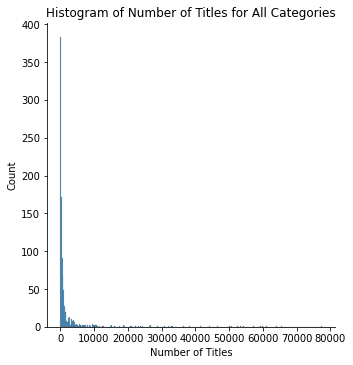

In [40]:
data = cat_data['category_numb_title']
plot = sns.displot(data)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles for All Categories")

#plt.show()
plt.savefig("./graphics/hist_cats.png", bbox_inches = 'tight')

In [34]:
big_bois = cat_data[cat_data['parent_category']== 'Audible'].filter(items = ['category_name','category_numb_title'])
big_bois.columns = ['Top Level Category Name','Number of Titles']
big_bois.set_index('Top Level Category Name')

,Number of Titles
Top Level Category Name,
Travel & Tourism,8631
Teen,18661
Sports & Outdoors,22415
Science Fiction & Fantasy,61202
Science & Engineering,17495
Romance,63904
Religion & Spirituality,55302
"Relationships, Parenting & Personal Development",58980
Politics & Social Sciences,59844


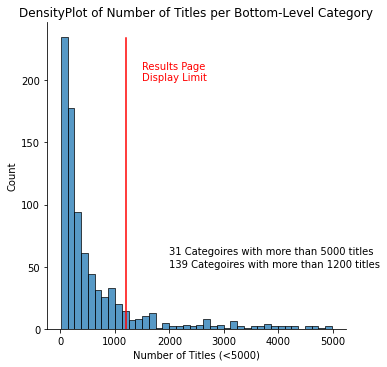

In [17]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']
plot = sns.displot(data2, bins = )

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
plt.text(x=1500, y=200, s= "Results Page \nDisplay Limit", color = 'r')

plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


#plt.show()
plt.savefig("./graphics/hist_leafs.png", bbox_inches = 'tight')

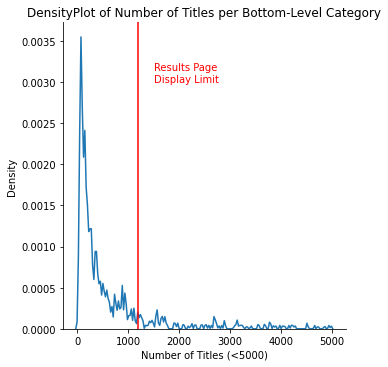

In [29]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']

plot = sns.displot(data2, kind = 'kde', bw_adjust = 0.05)

plt.axvline(1200, 0, 1, color = 'r')
plt.text(x=1500, y=0.003, s= "Results Page \nDisplay Limit", color = 'r')

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')

#plt.show()
plt.savefig("./graphics/density_leafs.png", bbox_inches = 'tight')

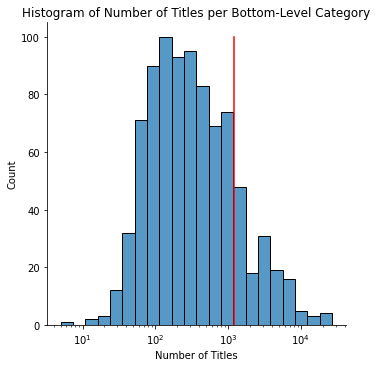

In [34]:
data2 = cat_data[cat_data['leaf_flag']==True]['category_numb_title']
plot = sns.displot(data2,log_scale = True)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
#plt.text(x=1500, y=200, s= "Results Page \nDisplay Limit", color = 'r')

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


plt.show()
#plt.savefig("./graphics/hist_log_leafs.png", bbox_inches = 'tight')

In [24]:
large_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >5000)]['category_numb_title']
print("There are {} leaf categories with more than 5000 titles.".format(len(large_leafs)))

display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
print("There are {} leaf categories with more than 1200 titles, the display limit.".format(len(display_limit_leafs)))

There are 31 leaf categories with more than 5000 titles.
There are 139 leaf categories with more than 1200 titles, the display limit.


In [5]:
cat_data[(cat_data['leaf_flag']==True)].shape

(869, 7)

In [41]:
display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
string = "{} is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories."
print(string.format(sum(display_limit_leafs)))

583153 is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories.


This offers the oppurtunity to expand these leaf-categories into sub-categories which could provide the user more choice. Significantly the top level category of **Erotica** only has two sub-categories **Literature & Fiction** and **Sexual Instruction** which is suprising considering Audible has a feature [specifically targeted](https://qz.com/1116293/audible-is-launching-a-feature-that-lets-you-jump-right-to-the-most-erotic-part-of-an-audiobook/) at this category of audiobooks. My best alternative hypothesis is most **Erotica/Literature & Fiction** titles are also represented in the **Romance** section which is broken down into many sub-categories.  

Personal Success might offer an easy split "Managing your vanity" and "How does my hair look?"

In [54]:
# Top and bottom categories
data2      = cat_data[cat_data['leaf_flag']==True]
top_       = data2.sort_values('category_numb_title',ascending = False).head(5)
bottom_    = data2.sort_values('category_numb_title',ascending = False).tail(5)
top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title'])
top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles']

#Get URL
#top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title', 'self_url'])
#top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles', 'Category URL']
#print(top_bottom.to_string())

top_bottom

,Parent Category,Category Name,Number of Titles
174,Personal Development,Personal Success,26798
823,Thriller & Suspense,Suspense,26385
597,Erotica,Literature & Fiction,23118
251,Romance,Contemporary,20868
925,Management & Leadership,Leadership,16045
857,Biographies,Adventurers & Explorers,18
396,"Health, Lifestyle & Relationships",Sexuality & Sexual Health,17
426,Historical Fiction,Action & Adventure,16
401,Science Fiction,Anthologies & Short Stories,13
587,Language Learning,Latin,5


426 : Teen / Lit & Fic / Historical Fiction / A & A

401 : Teen / Scifi & Fantasy / SciFi / Anthology...



#### Network Visualization

In [96]:
# adding a false entry to make assignments easier. 
cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

#Creating new column for better node visualization
cat_data['log_numb_title'] = np.log(cat_data['category_numb_title'])
cat_data['scaled_numb_title'] = np.interp(cat_data.category_numb_title,
                                         (cat_data.category_numb_title.min(),
                                         cat_data.category_numb_title.max()),
                                         (1,300))
cat_data['scaled_log_numb_title'] = np.interp(cat_data.log_numb_title,
                                         (cat_data.log_numb_title.min(),
                                         cat_data.log_numb_title.max()),
                                         (1,300))

ValueError: Received invalid argument(s): layout

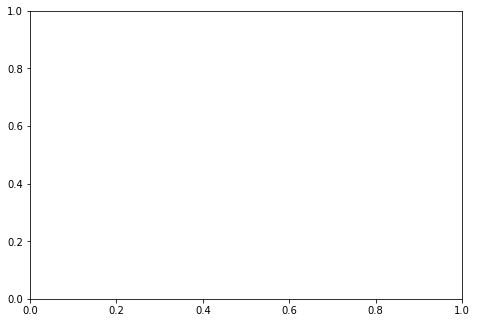

In [3]:
graph = nx.from_pandas_edgelist(cat_data, 'parent_url','self_url', create_using=nx.DiGraph())

node_info = cat_data.set_index('self_url').reindex(graph.nodes())
#node_dic  = node_info.filter(['category_name']).T.to_dict('dict')

nx.draw(graph, 
        with_labels = False,
        labels      = node_info['category_name'],
        arrows      = True,
        #node_color  = node_info['category_numb_title'],
        node_size   = node_info['category_numb_title'], # pretty good
        #node_size   = node_info['log_numb_title'], # very small points, 
        #node_size   = node_info['scaled_numb_title'], # very small points
        #node_size   = node_info['scaled_log_numb_title'], #visable points, too small
        #pos         = nx.fruchterman_reingold_layout(graph) #doesnt seem to work
        layout       = nx.kamada_kawai_layout(graph) #doesnt quite work
       )
#plt.rcParams['figure.figsize'] = (50,50)
plt.title("Audible Categories")
#plt.show()
#plt.savefig("category_network.png")




https://stackoverflow.com/questions/40092390/network-graph-is-not-visually-optimized-in-networkx

In [9]:
import graphviz
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

edges = list(zip(cat_data.parent_url, cat_data.self_url))


labels = dict(zip(cat_data.self_url,cat_data.category_name))


G = nx.DiGraph() # Create an empty Graph

for k,v in labels.items():
    G.add_node(k,label=v)
G.add_edges_from(edges)

A = to_agraph(G)

A.draw('hier_categories.png', prog='dot') # Hierarchical
A.draw('circular_categories.png', prog='neato') #circular

In [ ]:
import graphviz
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

graph = nx.DiGraph()
graph.add_nodes_from()
graph.add_edges_from()


# SOME EDA ABOUT THE categories

# Title information

#### Cleaning Duplicates and Filtering Podcasts
Since Audible treats categories more like tags, most titles belonging to multiple, there is a significant number of duplicated titles and information. 


Podcasts are also present in our data, which I didn't know Audible offered, but since they are not the focus of the scraping they are discarded. 

Number of titles scraped:  622065
Number of unique titles (books+pods):  286200
Unique Podcasts:  6959
Unique Books:  279241


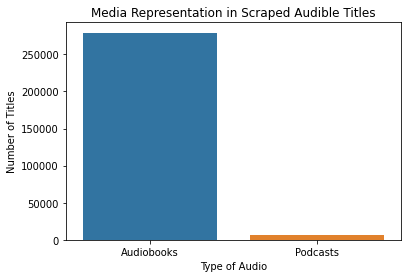

In [35]:
print("Number of titles scraped: ", len(title_data.title_url) )
print("Number of unique titles (books+pods): ", len(np.unique(title_data.title_url)))
print("Unique Podcasts: ",len(np.unique(title_data.title_url[title_data.pod_flag == True])))
print("Unique Books: ",len(np.unique(title_data.title_url[title_data.pod_flag == False])))

data = np.where(title_data.drop_duplicates(subset = ['title_url'])['pod_flag'] == True, "Podcasts", "Audiobooks" )
sns.countplot(x=data).set(xlabel="Type of Audio", ylabel = "Number of Titles")

plt.title("Media Representation in Scraped Audible Titles")

plt.savefig("./graphics/media_types.png", bbox_inches = 'tight')

In [36]:
# Remove podcasts from dataframe
title_data = title_data.loc[title_data.pod_flag == False]

Due to titles appearing in multiple categories, other fields were effected which were cleaned in the following manner.
- **title_category**: collapsed into a list.
- **count_rating**: max value retained.  
- **star_rating**: max value retained.
- **release_date**: max value retained. I believe this is due to reuploading into a new category.
- **length**: max value retained. I believe this is due to reuploading into a new category.
- **category_number**: New Column, number of categories a title was scraped in.

In [37]:
group_bys = list(title_data.columns)
group_bys.remove("title_category")
group_bys.remove("star_rating")
group_bys.remove("count_rating")
group_bys.remove("release_date")
group_bys.remove("length")

titles = title_data.groupby(group_bys, dropna = False).agg({
                                              'release_date'  :'max',
                                              'length'        :'max',
                                              'star_rating'   :'max', 
                                              'count_rating'  :'max',
                                              'title_category': lambda x: list(x)}
                                            ).reset_index()

titles['category_number'] = titles['title_category'].str.len()



"This leaves {} books remaining, compared to the +200,000 reported publically by Audible".format(len(np.unique(titles.title_url)))

'This leaves 279241 books remaining, compared to the +200,000 reported publically by Audible'

In [328]:
titles['author']   = [x.split(',') for x in titles.author.replace(np.nan,"")]
titles['narrator'] = [x.split(',') for x in titles.narrator.replace(np.nan,"")]

titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()

# EXAMINE NAs

#### Some fun facts

In [7]:
# To help make printing easier
def full_title(row):
    row = row.fillna("")
    return ("{0}: {1} written by {2}, narrated by {3}".format(row.title.values[0], row.subtitle.values[0], row.author.values[0], row.narrator.values[0]))

In [57]:
#titles.sort_values('count_rating', ascending=False).head(3).set_index("count_rating").apply(full_title,axis=1).reset_index().columns("Number of Ratings","Title Info")

top_counts = titles.sort_values('count_rating', ascending=False).head(3)
top_rating = titles[titles.star_rating == 5].sort_values('count_rating', ascending=False).head(3)
expensive  = titles.sort_values('price', ascending = False).head(3)
cheap      = titles.sort_values('price', ascending = True).head(3)



In [34]:
data = titles['category_number']
plot = sns.histplot(data, color = 'k')

plot.set_axis_labels("Number of Categories Title appears in")
plt.show()

NameError: name 'titles' is not defined

In [139]:
titles.sort_values('category_number', ascending = False).head(3)

,author,language,narrator,pod_flag,price,subtitle,title,title_url,release_date,length,star_rating,count_rating,title_category,category_number
260381,Timothy Snyder,English,Ralph Cosham,False,29.95,Europe Between Hitler and Stalin,Bloodlands,https://www.audible.com/pd/Bloodlands-Audioboo...,10-12-18,1096,5.0,390.0,"[United States, Austria & Hungary, Russia, Gre...",39
241047,Sherry Turkle,English,Laural Merlington,False,31.49,Why We Expect More from Technology and Less fr...,Alone Together,https://www.audible.com/pd/Alone-Together-Audi...,05-10-11,885,3.5,210.0,"[Philosophy, Workplace Culture, Workplace & Or...",35
30885,Brendan Simms,English,Leighton Pugh,False,30.79,A Global Biography,Hitler,https://www.audible.com/pd/Hitler-Audiobook/15...,10-01-19,1757,4.5,46.0,"[Japan, Austria & Hungary, Asia, Russia, Italy...",33


<AxesSubplot:xlabel='category_number', ylabel='star_rating'>

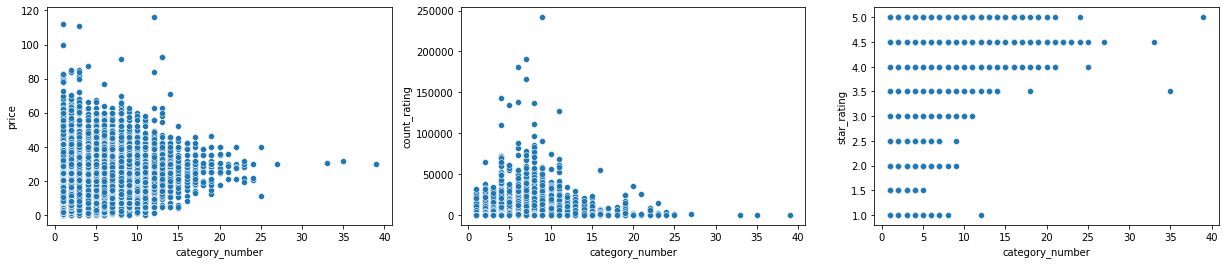

In [45]:
# price, reviews, rating by category number
#popular 

#sns.FacetGrid(titles, col = )

heat_data = zip(titles.category_number, )

fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(21)
sns.scatterplot(x=titles.category_number,
                y=titles.price,
                ax= axs[0])
sns.scatterplot(x=titles.category_number,
                y=titles.count_rating,
                ax= axs[1])
sns.scatterplot(x=titles.category_number,
                y=titles.star_rating,
                ax= axs[2])


# use density plots

- most prolific author, narrator
- author in most categories?
- narrator by category
- length vs price vs star/count
- space for audio dramas?
- category timeseries
- heard >3 hours is better than <3?
- https://news.ycombinator.com/item?id=27108326 
- price vs audible subscription price.
- increase in author being narrator
- length per price (bang for the buck)
- length of title/subtitle?

### Languages

In [69]:
s         = "There are {} languages represented in Audible's library."
numb_lang = len(titles.language.unique())

print(s.format(numb_lang))

There are 44 languages represented in Audible's library.


A large majority of audiobooks are narrated and avalible in English.

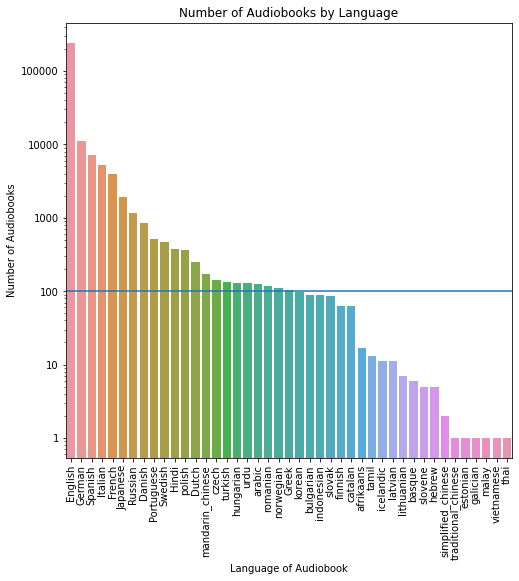

In [189]:
plot = sns.countplot(x='language', 
                     data = titles, 
                     order = titles['language'].value_counts().index)

plot.set_yscale('log')
plot.set_xlabel("Language of Audiobook")
plot.set_ylabel("Number of Audiobooks")
plot.axhline(y = 100)

plt.xticks(rotation =90)
yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)

plt.title("Number of Audiobooks by Language")
plt.rcParams['figure.figsize'] = (8,8)

plt.savefig("./graphics/languages.png", bbox_inches = 'tight')

English language audiobooks are the fastest language and show no signs of stopping. We can even see the expected releases in the comming years. 

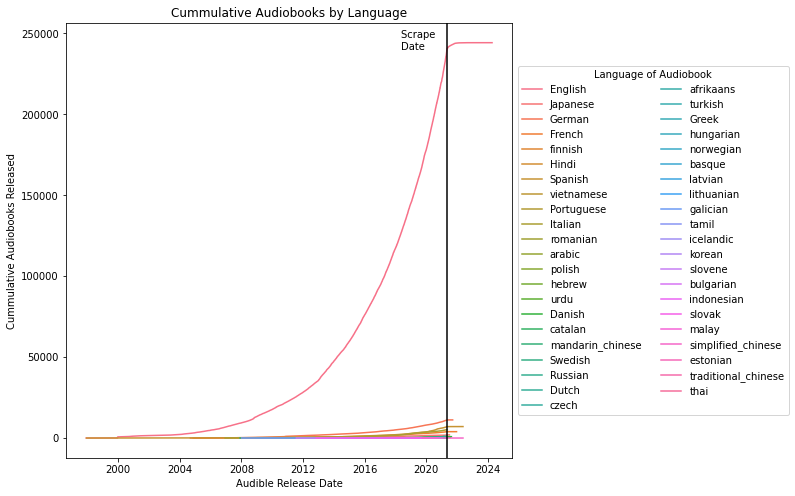

In [187]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()

plot = sns.lineplot(data= titles, 
             x   = 'pub_datetime', 
             y   = 'cumm_lang_pub',
             hue = 'language',
             ci  = None)

plt.title("Cummulative Audiobooks by Language")
plot.set_xlabel("Audible Release Date")
plot.set_ylabel("Cummulative Audiobooks Released")
plot.legend(title = "Language of Audiobook",
            loc='center right', 
            bbox_to_anchor=(1.63, 0.5), 
            ncol=2)

plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k')
plot.text(pd.to_datetime("2018-05-10"),240000, "Scrape \nDate", color ='k')

plt.savefig("./graphics/lang_timeseries.png", bbox_inches = 'tight')


### Author as Narrator

In [216]:
print(titles.narrator[4])
print(titles.author[4])

Tariq Ben Nuriddin Porter
'Abd Allah Al-Qar'awi


In [329]:
def are_you_me(author, narrator):
    if not isinstance(author, (str,list)) or not isinstance(narrator,(list,str)):
        return False
    if isinstance(author,str):
        author = [author]
    if isinstance(narrator,str):
        narrator = [narrator]
        
    print(narrator)
    print(author)
    return all([x in author for x in narrator])
        
        

In [330]:
titles.author[5]

['(in)Courage', 'Grace Cho - editor', 'Anna Rendell - editor']

In [332]:
for x in range(0,100):
    print(titles.author[x],"||||", titles.narrator[x])
    print(are_you_me(titles.author[x],titles.narrator[x]))

['"Sharkey" Ward'] |||| ['Nigel D MacCartan-Ward DSC AFC']
['Nigel D MacCartan-Ward DSC AFC']
['"Sharkey" Ward']
False
['"Triathlon Taren" Gesell'] |||| ['"Triathlon Taren" Gesell']
['"Triathlon Taren" Gesell']
['"Triathlon Taren" Gesell']
True
['"Triathlon Taren" Gesell'] |||| ['Taren Gesell']
['Taren Gesell']
['"Triathlon Taren" Gesell']
False
['"Triathlon" Taren Gesell'] |||| ['Taren Gesell']
['Taren Gesell']
['"Triathlon" Taren Gesell']
False
["'Abd Allah Al-Qar'awi"] |||| ['Tariq Ben Nuriddin Porter']
['Tariq Ben Nuriddin Porter']
["'Abd Allah Al-Qar'awi"]
False
['(in)Courage', 'Grace Cho - editor', 'Anna Rendell - editor'] |||| ['Susan Hanfield', 'Machelle Williams']
['Susan Hanfield', 'Machelle Williams']
['(in)Courage', 'Grace Cho - editor', 'Anna Rendell - editor']
False
['(株)文化放送'] |||| ['三笑亭 可楽']
['三笑亭 可楽']
['(株)文化放送']
False
['(株)文化放送'] |||| ['三笑亭 可楽']
['三笑亭 可楽']
['(株)文化放送']
False
['(株)文化放送'] |||| ['三笑亭 可楽']
['三笑亭 可楽']
['(株)文化放送']
False
['(株)文化放送'] |||| ['三笑亭 可楽']
['三笑亭 可楽']